In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import re
import math

# Process the Qualtrics Data

In [2]:
# Read the student responses into pandas dataframe
df_qt_resp = pd.read_excel('raw/0_karel_qualtrics.xlsx',sheet_name=0)
df_qt_resp = df_qt_resp.iloc[1:,:]
df_qt_resp = df_qt_resp.astype({'CS_Classes': 'int64','Experience':'int64'})
df_qt_resp.rename(columns={'Q42':'Teacher', 'Duration (in seconds)':'Duration'},inplace=True)#print(df_qt_resp)
num_stud_init = df_qt_resp.shape[0]
print(num_stud_init)

196


In [3]:
#Clean up student names
df_qt_resp.studid = df_qt_resp.studid.replace(to_replace=r"^'", value='', regex=True)

In [4]:
# Read the response keys into pandas dataframe
df_qt_answ = pd.read_excel('raw/0_karel_qualtrics.xlsx',sheet_name=1)
df_qt_answ.replace({'Q42':'Teacher'},inplace=True)
#print(df_qt_answ)

In [5]:
# Filter out rows with too many NaN
thresh_NaN = 5
is_NaN = df_qt_resp.isnull()
row_sum_NaN = is_NaN.filter(regex='^Q',axis=1).sum(axis=1)
df_qt_missingData = df_qt_resp[row_sum_NaN>=thresh_NaN]

df_qt_resp = df_qt_resp[row_sum_NaN<thresh_NaN]
num_stud_final = df_qt_resp.shape[0]
print(num_stud_final)

180


In [6]:
# Calculate Total Expertise
df_qt_resp['Expertise_sum'] = df_qt_resp.filter(regex='^Expertise_[^5sum]').sum(axis=1)

<AxesSubplot:ylabel='Frequency'>

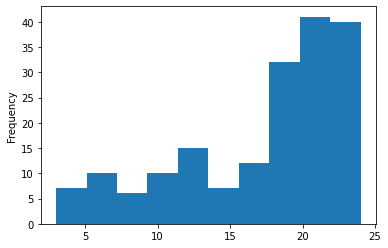

In [7]:
# Calculate the Score per question
for question in list(filter(lambda x: 'Q' in x ,df_qt_resp.columns.tolist())): #df_questions.columns.filter(regex=='^Q|stud'):
    if question == 'studid': continue
    right_answer = df_qt_answ['AnswerKey'].values[df_qt_answ['QuestionID']==question][0]
    df_qt_resp[question] = df_qt_resp[question].apply(lambda x: 0 if x != right_answer else 1)

if not 'total' in df_qt_resp.columns.values:
    df_qt_resp['totalScore'] = df_qt_resp[list(filter(lambda x: 'Q' in x ,df_qt_resp.columns.tolist()))].sum(axis=1)
df_qt_resp['totalScore'].plot.hist()

## Breakdown Score by Question

In [8]:
#Item Difficulty
df_questions = df_qt_resp.filter(regex='^Q|studid',axis=1)
df_itemAnalysis = pd.melt(df_questions, id_vars='studid').rename(columns={'variable':'question', 'value':'score'})
df_itemAnalysis = df_itemAnalysis['score'].groupby(df_itemAnalysis['question']).agg(itemDiff='mean', std='std').round(2)


In [9]:
#Item discrimination
df_questions = df_qt_resp.filter(regex='^Q|studid|totalScore',axis=1)
df_questions['TopLowScore'] = df_questions['totalScore'].apply(lambda x: -1 if x < df_questions.totalScore.quantile(0.45) else 
                                 (1 if x > df_questions.totalScore.quantile(0.55) else 0))
df_questions = df_questions.drop(df_questions[df_questions.TopLowScore == 0 ].index)

num_low = df_questions[df_questions.TopLowScore==-1].shape[0]
num_high = df_questions[df_questions.TopLowScore==1].shape[0]
num_mean = (num_low + num_high) / 2

df_itemAnalysis['itemDiscrim'] = 0
for questionID in list(filter(lambda x: 'Q' in x ,df_questions.columns.tolist())): #df_questions.columns.filter(regex=='^Q|stud'):

    #questionID = df_questions.columns.tolist()[16]

    num_correct_low = df_questions[questionID][df_questions.TopLowScore==-1].sum()
    num_correct_high = df_questions[questionID][df_questions.TopLowScore==1].sum()
    itemdisc = ((num_correct_high - num_correct_low) / num_mean).round(2)
    df_itemAnalysis.itemDiscrim[np.where(df_itemAnalysis.index ==questionID)[0]] = itemdisc
#    print(questionID,itemdisc)

/tmp/ipykernel_60/1478016162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_questions['TopLowScore'] = df_questions['totalScore'].apply(lambda x: -1 if x < df_questions.totalScore.quantile(0.45) else
/tmp/ipykernel_60/1478016162.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_itemAnalysis.itemDiscrim[np.where(df_itemAnalysis.index ==questionID)[0]] = itemdisc


In [10]:
df_itemAnalysis

,itemDiff,std,itemDiscrim
question,,,
Q16,0.88,0.32,0.27
Q17,0.80,0.40,0.52
Q18,0.78,0.41,0.34
Q19,0.42,0.50,0.51
Q20,0.69,0.46,0.52
Q21,0.78,0.42,0.48
Q22,0.80,0.40,0.45
Q23,0.59,0.49,0.41
Q24,0.73,0.45,0.46


## Correlation with Experience and total score

In [11]:
df_cor = df_qt_resp[['CS_Classes','Experience','totalScore','Expertise_sum']]
df_cor.corr()

,CS_Classes,Experience,totalScore,Expertise_sum
CS_Classes,1.000000,0.393649,-0.040809,0.442226
Experience,0.393649,1.000000,-0.049201,0.606033
totalScore,-0.040809,-0.049201,1.000000,0.293292
Expertise_sum,0.442226,0.606033,0.293292,1.000000


In [12]:
df_cor['Expertise_binned'] = df_cor['Expertise_sum'].apply(lambda x: 1 if x < df_cor.Expertise_sum.quantile(0.25) else 
(2 if x < df_cor.Expertise_sum.quantile(0.5) else 
(3 if x < df_cor.Expertise_sum.quantile(0.75) else 4)))

/tmp/ipykernel_60/3343141462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor['Expertise_binned'] = df_cor['Expertise_sum'].apply(lambda x: 1 if x < df_cor.Expertise_sum.quantile(0.25) else


In [13]:
df_cor['totalScore'].groupby(df_cor['Expertise_binned']).agg(avg= 'mean', std= 'std')

,avg,std
Expertise_binned,,
1,15.578947,5.683697
2,16.058824,5.586462
3,16.629032,5.726653
4,19.913043,3.482184


# Examine Process Data

In [14]:
df_all = df_qt_resp[['studid','Teacher','CS_Classes','Expertise_sum','totalScore']]

In [15]:
df_karel = pd.read_json('raw/1_karel_data.json',lines=False)
print(df_karel.columns)

Index(['sessionId', 'userId', 'teacherId', 'sessionName', 'anonymousId',
       'numStarts', 'sessionTimeSecs', 'sessionType', 'taskName', 'taskId',
       'order', 'nodeId', 'visitedAndLoaded', 'correct', 'timeOnTask',
       'hasExamples', 'goodExampleUsed', 'badExampleUsed', 'hasHint',
       'hintUsed'],
      dtype='object')


In [16]:
# See whether there is data missing
df_all['userInKarel'] = 0
#df_all.userInKarel.apply(lambda x: 1 if df_all.studid in df_karel.anonymousId.unique() else 0)
for idx, user in df_all['studid'].iteritems():
    if user in df_karel.anonymousId.unique():
        df_all.userInKarel.loc[idx] = 1
    else :
        df_all.userInKarel.loc[idx] = 0
    #print (user in df_karel.anonymousId.unique())

/tmp/ipykernel_60/2062745920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['userInKarel'] = 0
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
df_notInKarel = df_all.studid[df_all.userInKarel==0]
df_notInKarel.to_csv('raw/inQualtricsnotInKarel.csv')
print(len(df_notInKarel))

62


In [18]:
#students in karel data in missing qualtrics data? 
df_qt_missingData['userInKarel'] = 0
for idx, user in df_qt_missingData['studid'].iteritems():
    if user in df_karel.anonymousId.unique():
        df_qt_missingData.userInKarel.loc[idx] = 1
    else :
        df_qt_missingData.userInKarel.loc[idx] = 0
        
print(df_qt_missingData.userInKarel.sum())

16


In [19]:
df_qt_IDs = pd.read_csv('raw/3_allqualtricsIDs.csv')
df_qt_IDs['userInKarel'] = 0
for idx, user in df_qt_IDs['studid'].iteritems():
    if user in df_karel.anonymousId.unique():
        df_qt_IDs.userInKarel.loc[idx] = 1
    else :
        df_qt_IDs.userInKarel.loc[idx] = 0
        
print(df_qt_IDs.userInKarel.sum())
print(df_all.userInKarel.sum())
print(df_qt_IDs.shape[0])

156
118
244


In [20]:
#Students who are test cases
df_teacherStudent = pd.read_csv('raw/4_Teacher_Student.csv')
df_all['testCases'] = 0
for studIdx, stud in df_all.iterrows():
    studId = stud.studid
    if (studId in df_teacherStudent['Nickname Id'].unique()):
        teacherIdx = df_teacherStudent.index[df_teacherStudent['Nickname Id'] == studId].tolist()[0]
        teacherName = df_teacherStudent.Name[teacherIdx]
        if pd.isna(teacherName) or df_teacherStudent.Testing[teacherIdx]==True:  
#        if math.isnan(df_teacherStudent.Name[teacherIdx]) :
            df_all['testCases'][studIdx] = 1
#    else:
#        print (studId,'%', df_all.Teacher[studIdx], '%' , df_all.userInKarel[studIdx])

/tmp/ipykernel_60/3126921589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['testCases'] = 0
/tmp/ipykernel_60/3126921589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['testCases'][studIdx] = 1


In [21]:
# Calculate which students to finally include in the data
df_all['includeInAnalysis'] = [a*b for a,b in zip(df_all.userInKarel.tolist(),(1 - np.array(df_all.testCases.tolist())))]
print(df_all.includeInAnalysis.sum())

98


/tmp/ipykernel_60/442302956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['includeInAnalysis'] = [a*b for a,b in zip(df_all.userInKarel.tolist(),(1 - np.array(df_all.testCases.tolist())))]


# Possible plans and questions
* Will there be students that are bad on the paper test but good on the programming task, and vice versa? 
* What does the Karel task buy us? 
* We expect good programmers to do well on both. Are there students who do poorly on the paper exam but have good practices, they should do better on the programming task? Can we differentiate in Karel between students in the low score bracket?
* What are the behaviors we can find in student programming?

Next steps:
* Calculate the total scores: Do we want to normalize the scores based on how far they got? Give more credit for going further?
* Measure of attempt / effort? Link between tried and solved?
* Predictive by bin on qualtrics? and based on sessions?
* Help seeking as mediator?
* For qualtrics: IRT to get estimates of ability?

Later analyses:
* Is there difference in prediction by task type?
    * Debugging tasks in qualtrics, debugging tasks in experience, etc.

In [22]:
# Analyze for what students we have what session data

df_karel['sessionTaskName'] = df_karel['sessionType'].astype(str).apply(lambda x: x[:1]) + '_' + df_karel['taskName']
df_karel['experimentGroup'] = df_karel['sessionType'].astype(str).apply(lambda x: x[1:])
df_karel['sessionNumber'] = df_karel['sessionType'].astype(str).apply(lambda x: x[:1])

# Creating one column that takes into account whether students visited and loaded task but were false or did not visit
df_karel['visitedAndCorrect'] = 0

num_rows = 0

for idx,user in df_karel.iterrows():
    if not user.visitedAndLoaded:
        df_karel.visitedAndCorrect.loc[idx] = -1
    elif user.visitedAndLoaded and not user.correct:
        df_karel.visitedAndCorrect.loc[idx] = 0
    elif user.visitedAndLoaded and user.correct:
        df_karel.visitedAndCorrect.loc[idx] = 1
        
userIds = df_karel.anonymousId.unique()
userIds = userIds[:(len(userIds)-1)]
userIds = pd.DataFrame(userIds,columns=['userId'])

num_only2 = 0
num_only3 = 0
num_2A3B_2B3A = 0
for idx,user in userIds.iterrows():
    
    df_tmp = df_karel.loc[df_karel.anonymousId == user.userId]
    df_tmp = df_tmp.loc[df_tmp.sessionType != 'Survey']

    if len(df_tmp):
        if len(df_tmp.sessionNumber.unique()) == 1:
            if df_tmp.sessionNumber.unique()[0] == '2':
                num_only2 += 1
            else: 
                num_only3 += 1
        else:
            sessionTypes = df_tmp.sessionType.unique()
            if len(sessionTypes) == 2 and (('2A' in sessionTypes and '3B' in sessionTypes) or \
                                          ('2B' in sessionTypes and '3A' in sessionTypes)):
                num_2A3B_2B3A += 1 
                
print(num_only2,' ',num_only3,' ',num_2A3B_2B3A)
                          

35   4   12


In [23]:
# DO NOT EXECUTE 
# Based on the previous analysis, include only session 2 data. 
df_karel = df_karel.loc[df_karel.sessionNumber=='2']
len(df_karel.anonymousId.unique())

116

In [24]:
# Remove the duplicate lines for each person and task
# For each person and each task, find the duplicate lines. 
# If one is correct, remove the false one. 
# If both are correct or false, keep one at random and remove the other.
num_rows = 0
        
df_karelNoDuplicates = pd.DataFrame(columns=df_karel.columns)
        
userIds = df_karel.anonymousId.unique()
userIds = userIds[:(len(userIds)-1)]
userIds = pd.DataFrame(userIds,columns=['userId'])

for idx,user in userIds.iterrows():
    
    df_tmp = df_karel.loc[df_karel.anonymousId == user.userId]
    df_tmp = df_tmp.loc[df_tmp.sessionType != 'Survey']
    df_tmp = df_tmp.loc[df_tmp.taskName != 'Tutorial']
    df_tmp = df_tmp.loc[df_tmp.taskName != 'Participant Survey']
    df_tmp = df_tmp.loc[df_tmp.taskName != 'Intro']
    #if len(df_tmp['sessionType'].astype(str).apply(lambda x: x[1:]).unique()) > 1:
    #    print(df_tmp['sessionType'].astype(str).apply(lambda x: x[1:]).value_counts())
    
    sessionTaskNames = df_tmp.sessionTaskName.unique();
    for taskName in sessionTaskNames:
        
        df_task = df_tmp.loc[df_tmp.sessionTaskName == taskName]#.loc[df_tmp.sessionType == user.sessionType]

        df_add = pd.DataFrame(columns=df_karel.columns)
        
        num_correct = df_task.correct.sum()
        num_visited = df_task.visitedAndLoaded.sum()
        
        if  len(df_task.experimentGroup.unique().tolist()) == 1: # Only one session type for all task instances
            sessionType = df_task.experimentGroup.unique().tolist()[0]
             
            sortByTime = False
            
            if df_task.shape[0] == 1: # If no duplicates
                num_rows += 1
                df_add = df_task
            elif df_task.shape[0] > 1: # If duplicates
                
                if num_correct == 1: # If only one correct
                    num_rows += 1
                    df_add = df_task.loc[df_task.correct==True]
                    
                elif num_correct > 1: # If more correct                                  
                    df_task = df_task.loc[df_task.correct==True]
                    sortByTime = True
                    
                elif (not num_correct) and num_visited == 1: # None correct, but only one visited
                    num_rows += 1
                    df_add = df_task.loc[df_task.visitedAndLoaded==True]
                    
                elif (not num_correct) and num_visited > 1: # None correct, and more than one visited
                    df_task = df_task.loc[df_task.visitedAndLoaded==True]
                    sortByTime = True

                elif (not num_correct) and (not num_visited): # None correct, and none visited
                    sortByTime = True
                            
                else:
                    print('need more cases')
                            
            else: 
                print('we have a problem', ' ', df_task)
                        
        else: # If there are more than 1 session types
            # select the one that has been visited
            # select the one with the longer time
            
            if num_correct == 1:
                num_rows += 1
                df_add = df_task.loc[df_task.correct==True]

            elif num_visited == 1:
                num_rows += 1
                df_add = df_task.loc[df_task.visitedAndLoaded==True]
            
            elif num_correct > 1:
                df_task = df_task.loc[df_task.correct==True]
                sortByTime = True
            
            elif num_visited > 1:
                df_task = df_task.loc[df_task.visitedAndLoaded==True]
                sortByTime = True
            
            elif (not num_visited) and len(df_task) > 1:
                sortByTime = True
                
            else:
                print('we should not be here')
                print(df_task)
        
        if sortByTime:             
            
            if len(np.where(df_task.timeOnTask == df_task.timeOnTask.max())[0]) == 1:
                num_rows += 1
                df_add = df_task.loc[df_task.timeOnTask == df_task.timeOnTask.max()]
            else: 
                num_rows +=1
                
                if len(df_task.sessionType.unique())>1:
                    if len(np.where(df_tmp.sessionType.value_counts() == np.max(df_tmp.sessionType.value_counts()))[0])==1:
                        sessionType = df_tmp.sessionType.value_counts()[np.where(df_tmp.sessionType.value_counts() == \
                                                                         np.max(df_tmp.sessionType.value_counts()))[0]].index[0]
                        
                        if len(df_task.loc[df_task.sessionType == sessionType])<1:
                            print(df_tmp)
                            print(df_task)
                        df_task = df_task.loc[df_task.sessionType == sessionType]

                df_add = df_task.sample()                
        
        if len(df_add) != 1:
            print('the length of df_add is not right')
        
        elif len(df_karelNoDuplicates) > 0:
            df_add = df_add.reset_index(drop=True)
        
            if len(df_karelNoDuplicates\
                    .loc[df_karelNoDuplicates.anonymousId==df_add.anonymousId[0]]\
                    .loc[df_karelNoDuplicates.sessionType==df_add.sessionType[0]]\
                    .loc[df_karelNoDuplicates.taskName==df_add.taskName[0]]) > 0 :
                continue
                
        df_karelNoDuplicates = pd.concat([df_karelNoDuplicates,df_add], ignore_index=True, sort=False)

In [25]:
df_session2data = df_karelNoDuplicates[['anonymousId','sessionTaskName','visitedAndCorrect']].pivot(index='anonymousId',columns='sessionTaskName',values='visitedAndCorrect')
for idx,user in df_session2data.iterrows():
    if pd.isna(user['2_Task 4: Debug Function']):
        df_session2data['2_Task 4: Debug Function'][idx]=df_session2data['2_Task 4: Debug Functions'][idx]
df_session2data.drop(columns=['2_Task 4: Debug Functions'],inplace=True)
df_session2data

df_session2data['experimentGroup'] = 0

for userIdx,userData in df_session2data.iterrows():     
    df_tmp = df_karelNoDuplicates.loc[df_karelNoDuplicates.anonymousId == userIdx]
    if len(df_tmp.sessionType.unique()) == 1:
        df_session2data.experimentGroup[userIdx] = df_tmp.sessionType.unique()[0][1:]
        #print(df_tmp.sessionType.value_counts())
        #print(df_tmp)
    else:
        sessionType = df_tmp.sessionType.value_counts()[np.where(df_tmp.sessionType.value_counts() == \
                                                                         np.max(df_tmp.sessionType.value_counts()))[0]].index[0][1:]
        df_session2data.experimentGroup[userIdx] = sessionType

/tmp/ipykernel_60/1388343020.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session2data.experimentGroup[userIdx] = df_tmp.sessionType.unique()[0][1:]


/tmp/ipykernel_60/3362519065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[df_tmp==-1] = 0
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


<AxesSubplot:ylabel='Frequency'>

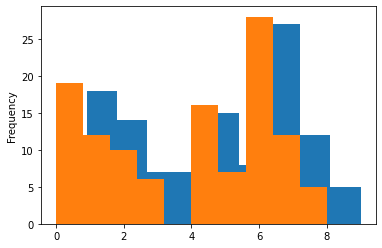

In [26]:
# Create total score for session 2

df_tmp = df_session2data[list(filter(lambda x: 'Task' in x ,df_session2data.columns.tolist()))]
df_tmp[df_tmp==-1] = 0
df_session2data['totalScore'] = df_tmp.sum(axis=1)
df_session2data['totalScoreWithoutFirst'] = df_tmp[list(filter(lambda x: '2_Task 1: Intro Function' not in x ,df_tmp.columns.tolist()))].sum(axis=1)

df_session2data.totalScore.plot.hist()
df_session2data.totalScoreWithoutFirst.plot.hist()


In [27]:
#Add the total score column to df_all
df_all['totalScoreSession2'] = 0
df_all['totalScoreSession2WithoutFirst'] = 0
df_all['experimentGroup'] = 0
for userIdx, user in df_all.iterrows():
    if user.studid in df_session2data.index:
        df_all.totalScoreSession2[userIdx] = df_session2data.totalScore[user.studid]
        df_all.totalScoreSession2WithoutFirst[userIdx] = df_session2data.totalScoreWithoutFirst[user.studid]        
        df_all.experimentGroup[userIdx] = df_session2data.experimentGroup[user.studid]  

/tmp/ipykernel_60/1443814937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['totalScoreSession2'] = 0
/tmp/ipykernel_60/1443814937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['totalScoreSession2WithoutFirst'] = 0
/tmp/ipykernel_60/1443814937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [28]:
# data set to be analyzed with complete data
df_finalData = df_all.loc[df_all.includeInAnalysis==1]
df_finalData

,studid,Teacher,CS_Classes,Expertise_sum,totalScore,userInKarel,testCases,includeInAnalysis,totalScoreSession2,totalScoreSession2WithoutFirst,experimentGroup
1,eJ4PR6Fagtg6QJaEiPW5mRZPW4Su60Z/Fo5zf9s+NCw=,Mr Chen Zenghui,3,11.0,23,1,0,1,8,7,A
2,6s4q+BaiL5aAyq05fOJ4/I36jlhPqy252nqoiQms+Ec=,Mr Chen,5,11.0,6,1,0,1,5,4,B
3,0pX3gW2KXGHBOf+jkUtF5tSEb0T4CQxz1wCOan6Kp0c=,MS chua,1,4.0,19,1,0,1,5,4,B
4,q4bTMhFYK9JysIaPu/Glne6t49okkmCplDFt4+Lnjio=,Chan may lun,3,9.0,13,1,0,1,7,6,B
5,+EIBAvzNzZ9JHmqlY2usTLt6sk+JpU4l7Drkz+VIsTk=,Ms Chua,5,9.0,22,1,0,1,9,8,A
...,...,...,...,...,...,...,...,...,...,...,...
126,RKry6gjnB3ssqCzqvopiYb5xABEshZDxX6mHfVf2jEo=,Mrs O'leary,5,6.0,11,1,0,1,5,4,A
127,ueOGolSbJiSpWudwzMwpAOpEu5ggzBCT55T2OfOvoiM=,Mrs O'Leary,5,8.0,12,1,0,1,7,6,A
131,wPrrqhpPmPLOm3i4eybbGlJQjy9Wk4fhJJbO0PUfERs=,ms o leary,5,7.0,7,1,0,1,3,2,A
132,jLT3jPQPhNTJIKqXfXc2dAfAlHr1WDEQTF/Gejb+rw4=,Ms O'Leary,5,10.0,12,1,0,1,1,0,A


In [29]:
#df_finalData['totalScoreSession2WithoutFirst'].groupby(df_finalData['experimentGroup']).agg(score='mean', std='std').round(2)
df_session2data['2_Bonus Task'].groupby(df_session2data['experimentGroup']).agg(score='mean', std='std').round(2)

,score,std
experimentGroup,,
A,-0.62,0.60
B,-0.59,0.56


In [30]:
df_cor = df_finalData[['Expertise_sum','totalScore','totalScoreSession2']]
df_cor.corr()

,Expertise_sum,totalScore,totalScoreSession2
Expertise_sum,1.000000,0.459843,0.483192
totalScore,0.459843,1.000000,0.735311
totalScoreSession2,0.483192,0.735311,1.000000


In [46]:
df_questions.columns

Index(['2_Bonus Task', '2_Task 1: Intro Function',
       '2_Task 2: Complete Function', '2_Task 3: Simplify Code',
       '2_Task 4: Debug Function', '2_Task 5: Intro While',
       '2_Task 6: Complete While', '2_Task 7: Solve with While',
       '2_Task 8: Debug While'],
      dtype='object', name='sessionTaskName')

In [32]:
# ANALYSE ITEM DIFFICULTY AND DISCRIMINATION FOR THE SESSION 2 TASKS

#Item Difficulty
df_questions = df_session2data.filter(regex='Task|anonymousId',axis=1)
df_itemAnalysis = pd.melt(df_questions, id_vars='anonymousId').rename(columns={'sessionTaskName':'question', 'value':'score'})
df_itemAnalysis.score[df_itemAnalysis.score==-1] = 0
df_itemAnalysis = df_itemAnalysis['score'].groupby(df_itemAnalysis['question']).agg(itemDiff='mean', std='std').round(2)
df_itemAnalysis

KeyError: 'anonymousId'

In [297]:
df_session2data

sessionTaskName,2_Bonus Task,2_Task 1: Intro Function,2_Task 2: Complete Function,2_Task 3: Simplify Code,2_Task 4: Debug Function,2_Task 5: Intro While,2_Task 6: Complete While,2_Task 7: Solve with While,2_Task 8: Debug While,experimentGroup,totalScore,anonymousId
anonymousId,,,,,,,,,,,,
+EIBAvzNzZ9JHmqlY2usTLt6sk+JpU4l7Drkz+VIsTk=,1,1,1,1,1,1,1,1,1,A,9.0,+EIBAvzNzZ9JHmqlY2usTLt6sk+JpU4l7Drkz+VIsTk=
+I6Lm2xSDwLNUdS7McSqmSZ83rgMWLhYQXDWw6rfIUg=,-1,1,1,0,-1,-1,-1,-1,-1,A,2.0,+I6Lm2xSDwLNUdS7McSqmSZ83rgMWLhYQXDWw6rfIUg=
+O9tbaXqYnEl2zrHwqyszwP8eDWjouEI9gg4zkIwPCI=,1,1,1,1,1,1,1,1,1,A,9.0,+O9tbaXqYnEl2zrHwqyszwP8eDWjouEI9gg4zkIwPCI=
/STtq4JiYrLwQsaO440o8QbdVrtgJVdgo5F1jYIKCmU=,-1,1,1,1,0,1,1,0,-1,A,5.0,/STtq4JiYrLwQsaO440o8QbdVrtgJVdgo5F1jYIKCmU=
0bZqaBxaqrJi/o1HIRxv/6FFqKD1HhF9J2jhWpotIF4=,1,1,1,1,1,1,1,1,1,B,9.0,0bZqaBxaqrJi/o1HIRxv/6FFqKD1HhF9J2jhWpotIF4=
...,...,...,...,...,...,...,...,...,...,...,...,...
z++fhJvGCK0DjUoqg99CUsnrFz2xK4UXEFsS6hyIREo=,0,1,1,1,0,1,1,1,1,B,7.0,z++fhJvGCK0DjUoqg99CUsnrFz2xK4UXEFsS6hyIREo=
zDm2VT7yQ3pIBGmStgP3Sxr0IjTD+7kM6PljHeBWShk=,0,1,1,0,0,1,1,1,0,B,5.0,zDm2VT7yQ3pIBGmStgP3Sxr0IjTD+7kM6PljHeBWShk=
zcW38sTxBaBFb9pBi4EQ8W5WEMzZpG71y6igQm/GLhU=,-1,1,1,1,0,1,1,0,0,B,5.0,zcW38sTxBaBFb9pBi4EQ8W5WEMzZpG71y6igQm/GLhU=


In [271]:
df_session2data = df_session2data.rename(columns={'anonymousid':'anonymousId'})

In [296]:
#Item discrimination
#df_questions = pd.DataFrame(df_session2data.filter(regex='Task|anonymouseId|totalScore',axis=1))
df_questions = df_session2data[list(filter(lambda x: 'Task' in x or 'anonymousId' in x or 'totalScore' in x ,df_session2data.columns.tolist()))]
df_questions[df_questions==-1] = 0
df_questions['TopLowScore'] = df_questions['totalScore'].apply(lambda x: -1 if x < df_questions.totalScore.quantile(0.45) else 
                                 (1 if x > df_questions.totalScore.quantile(0.55) else 0))
df_questions = df_questions.drop(df_questions[df_questions.TopLowScore == 0 ].index)

num_low = df_questions[df_questions.TopLowScore==-1].shape[0]
num_high = df_questions[df_questions.TopLowScore==1].shape[0]
num_mean = (num_low + num_high) / 2

df_itemAnalysis['itemDiscrim'] = 0
for questionID in list(filter(lambda x: 'Task' in x ,df_questions.columns.tolist())): #df_questions.columns.filter(regex=='^Q|stud'):

    #questionID = df_questions.columns.tolist()[16]

    num_correct_low = df_questions[questionID][df_questions.TopLowScore==-1].sum()
    num_correct_high = df_questions[questionID][df_questions.TopLowScore==1].sum()
    
    itemdisc = ((num_correct_high - num_correct_low) / num_mean).round(2)
    df_itemAnalysis.itemDiscrim[np.where(df_itemAnalysis.index ==questionID)[0]] = itemdisc
#    print(questionID,itemdisc)
df_itemAnalysis

TypeError: Cannot do inplace boolean setting on mixed-types with a non np.nan value

In [47]:
df_questions

sessionTaskName,2_Bonus Task,2_Task 1: Intro Function,2_Task 2: Complete Function,2_Task 3: Simplify Code,2_Task 4: Debug Function,2_Task 5: Intro While,2_Task 6: Complete While,2_Task 7: Solve with While,2_Task 8: Debug While
anonymousId,,,,,,,,,
+EIBAvzNzZ9JHmqlY2usTLt6sk+JpU4l7Drkz+VIsTk=,1,1,1,1,1,1,1,1,1
+I6Lm2xSDwLNUdS7McSqmSZ83rgMWLhYQXDWw6rfIUg=,-1,1,1,0,-1,-1,-1,-1,-1
+O9tbaXqYnEl2zrHwqyszwP8eDWjouEI9gg4zkIwPCI=,1,1,1,1,1,1,1,1,1
/STtq4JiYrLwQsaO440o8QbdVrtgJVdgo5F1jYIKCmU=,-1,1,1,1,0,1,1,0,-1
0bZqaBxaqrJi/o1HIRxv/6FFqKD1HhF9J2jhWpotIF4=,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
z++fhJvGCK0DjUoqg99CUsnrFz2xK4UXEFsS6hyIREo=,0,1,1,1,0,1,1,1,1
zDm2VT7yQ3pIBGmStgP3Sxr0IjTD+7kM6PljHeBWShk=,0,1,1,0,0,1,1,1,0
zcW38sTxBaBFb9pBi4EQ8W5WEMzZpG71y6igQm/GLhU=,-1,1,1,1,0,1,1,0,0


# Comments by Jason
* Go by task name and not task id.
* Make sure, session name is not part of stud id
* Catch some of the files that might not work.
* Scripts:
** The final data output should be: Summary for every kid and task. 
** First run matt's analyzer -->  outputs only task info
* There should not be a problem with duplicate session files for the same students.